In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.metrics import accuracy_score, hamming_loss

from tqdm.auto import tqdm
from timeit import default_timer as timer

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def print_train_time(start, end):
    print(f"\ntrain time: {end - start}")

In [4]:
data = pd.read_csv("drug_consumption.csv")

In [5]:
df = data.copy()

In [6]:
df = df.drop(columns=['ID'])

In [7]:
df.columns

Index(['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore',
       'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol',
       'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack',
       'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms',
       'Nicotine', 'Semer', 'VSA'],
      dtype='object')

In [8]:
features = df.select_dtypes(include=['number']).columns
labels = df.select_dtypes(include=['object']).columns

In [9]:
#{i:len(df[i].value_counts()) for i in num_cols}
cat_cols = [i for i in features if len(df[i].value_counts()) < 10]
cat_cols

['Age', 'Gender', 'Education', 'Country', 'Ethnicity']

### Age

In [10]:
start = 24
temp = [[18 if i == 0 else start + 10*(i-1) + 1, start + 10*i] for i in range(5)]
age_groups = [f"{i[0]} - {i[1]}" for i in temp]
age_groups.append("65+")
Age_map = {j:age_groups[i] for i, j in enumerate(sorted(df[cat_cols[0]].unique()))}
Age_map

{np.float64(-0.95197): '18 - 24',
 np.float64(-0.07854): '25 - 34',
 np.float64(0.49788): '35 - 44',
 np.float64(1.09449): '45 - 54',
 np.float64(1.82213): '55 - 64',
 np.float64(2.59171): '65+'}

### Gender

In [11]:
Gender_map = dict(zip(df[cat_cols[1]].unique(), ["Female", "Male"]))
Gender_map

{np.float64(0.48246): 'Female', np.float64(-0.48246): 'Male'}

### Education

In [12]:
education_groups = ["Left School Before 16 years",
"Left School at 16 years",
"Left School at 17 years",
"Left School at 18 years",
"Some College,No Certificate Or Degree",
"Professional Certificate/ Diploma",
"University Degree",
"Masters Degree",
"Doctorate Degree"]
Education_map = dict(zip(sorted(df[cat_cols[2]].unique()), education_groups))
Education_map

{np.float64(-2.43591): 'Left School Before 16 years',
 np.float64(-1.7379): 'Left School at 16 years',
 np.float64(-1.43719): 'Left School at 17 years',
 np.float64(-1.22751): 'Left School at 18 years',
 np.float64(-0.61113): 'Some College,No Certificate Or Degree',
 np.float64(-0.05921): 'Professional Certificate/ Diploma',
 np.float64(0.45468): 'University Degree',
 np.float64(1.16365): 'Masters Degree',
 np.float64(1.98437): 'Doctorate Degree'}

### Country

In [13]:
Country_map = {-0.09765 : "Australia",
0.24923 : "Canada",
-0.46841 : "New Zealan",
-0.28519 : "Other",
0.21128 : "Republic of Ireland",
0.96082 : "UK",
-0.57009 : "USA"}
Country_map

{-0.09765: 'Australia',
 0.24923: 'Canada',
 -0.46841: 'New Zealan',
 -0.28519: 'Other',
 0.21128: 'Republic of Ireland',
 0.96082: 'UK',
 -0.57009: 'USA'}

### Ethnicity

In [14]:
Ethnicity_map  = {-0.50212 : "Asian",
-1.10702 : "Black",
1.90725 : "Mixed-Black/Asian",
0.12600 : "Mixed-White/Asian",
-0.22166 : "Mixed-White/Black",
0.11440 : "Other",
-0.31685 : "White"}
Ethnicity_map

{-0.50212: 'Asian',
 -1.10702: 'Black',
 1.90725: 'Mixed-Black/Asian',
 0.126: 'Mixed-White/Asian',
 -0.22166: 'Mixed-White/Black',
 0.1144: 'Other',
 -0.31685: 'White'}

In [15]:
Label_map = {"CL0" : "Never Used",
"CL1" : "Used over a Decade Ago",
"CL2" : "Used in Last Decade",
"CL3" : "Used in Last Year",
"CL4" : "Used in Last Month",
"CL5" : "Used in Last Week",
"CL6" : "Used in Last Day"}
Label_map

{'CL0': 'Never Used',
 'CL1': 'Used over a Decade Ago',
 'CL2': 'Used in Last Decade',
 'CL3': 'Used in Last Year',
 'CL4': 'Used in Last Month',
 'CL5': 'Used in Last Week',
 'CL6': 'Used in Last Day'}

In [16]:
maps = [Age_map, Gender_map, Education_map, Country_map, Ethnicity_map]

for i, j in enumerate(maps):
    df[cat_cols[i]] = df[cat_cols[i]].map(j)

In [17]:
df = df.drop(["Semer", "Ethnicity"], axis=1)

In [18]:
np.unique(df["Age"])

array(['18 - 24', '25 - 34', '35 - 44', '45 - 54', '55 - 64', '65+'],
      dtype=object)

In [19]:
df["Age"] = df["Age"].replace({'65+' : '55 - 64'})
df["Age"] = df["Age"].replace({'55 - 64' : '55+'})

In [20]:
df.loc[(df['Country']=='Australia')|(df['Country']=='Canada')|(df['Country']=='New Zealand')|(df['Country']=='Other')|(df['Country']=='Republic of Ireland'),'Country']='Other_countries'

In [21]:
stimulants = ["Choc","Caff","Amphet", "Coke", "Crack", "Meth", "Nicotine"]
depressants = ["Alcohol", "Benzos", "Heroin", "Legalh", "Amyl", "VSA"]
hallucinogens = ["LSD", "Mushrooms", "Ketamine", "Cannabis", "Ecstasy"]

In [22]:
df.head()

,Age,Gender,Education,Country,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,...,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA
0,35 - 44,Female,Professional Certificate/ Diploma,UK,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0
1,25 - 34,Male,Doctorate Degree,UK,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,...,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0
2,35 - 44,Male,Professional Certificate/ Diploma,UK,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0
3,18 - 24,Female,Masters Degree,UK,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,...,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0
4,35 - 44,Female,Doctorate Degree,UK,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,...,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0


In [23]:
## df.to_csv("drug.csv")

In [24]:
score_cols = df.iloc[:, 4:(4+7)].columns
demo_cols = df.iloc[:, :4].columns
drug_cols = df.iloc[:, 11:].columns

In [25]:
np.unique(df.Alcohol)

array(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'], dtype=object)

In [26]:
stimulants = ["Choc","Caff","Amphet", "Coke", "Crack", "Meth", "Nicotine"]
depressants = ["Alcohol", "Benzos", "Heroin", "Legalh", "Amyl", "VSA"]
hallucinogens = ["LSD", "Mushrooms", "Ketamine", "Cannabis", "Ecstasy"]

In [27]:
dff = df.copy()

In [28]:
for drug in stimulants:
    dff[drug] = dff[drug].apply(lambda x: 0 if x in ["CL0", "CL1", "CL2"] else 1)

for drug in depressants:
    dff[drug] = dff[drug].apply(lambda x: 0 if x in ["CL0", "CL1", "CL2"] else 1)

for drug in hallucinogens:
    dff[drug] = dff[drug].apply(lambda x: 0 if x in ["CL0", "CL1", "CL2"] else 1)

In [29]:
dff['Stimulants'] = dff[stimulants].max(axis=1)
dff['Depressants'] = dff[depressants].max(axis=1)
dff['Hallucinogens'] = dff[hallucinogens].max(axis=1)

In [30]:
dff = dff.drop(columns=drug_cols)

In [31]:
drug_cat = ["Stimulants","Depressants","Hallucinogens"]

In [32]:
class OneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse_output=False, drop='first')

    def fit(self, X, y=None):
        if (self.columns is not None):
            self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        if (self.columns is not None):
            onehot_encoded = self.encoder.transform(X[self.columns])
            feature_names = self.encoder.get_feature_names_out()
            result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
            return pd.concat([X.drop(columns=self.columns), result_df], axis=1)
        else:
            return X

In [33]:
class Ordinal(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, custom_categories=None):
        """
        columns: list of column names to be encoded.
        custom_categories: list of lists specifying the order of categories for each column.
        """
        self.columns = columns
        self.custom_categories = custom_categories
        self.encoder = OrdinalEncoder(categories=custom_categories)

    def fit(self, X, y=None):
        if self.columns is not None:
            self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        if self.columns is not None:
            ordinal_encoded = self.encoder.transform(X[self.columns])
            result_df = pd.DataFrame(ordinal_encoded, columns=self.columns, index=X.index)
            return pd.concat([X.drop(columns=self.columns), result_df], axis=1)
        else:
            return X

In [34]:
# oneHot = OneHot(demo_cols[demo_cols != "Education"])
# X = oneHot.fit_transform(pd.concat([df[demo_cols],  df[score_cols]], axis=1))
# ordinal = Ordinal(["Education"], [education_groups])
# X = ordinal.fit_transform(X)

In [35]:
y = dff[drug_cat]
# usage_map = dict(zip(np.unique(y), np.array([0, 0, 0, 1, 1, 1, 1])))
# y = y.replace(usage_map)

In [36]:
X = dff[score_cols]

In [ ]:
# df['stimulants'] = df[["Choc", "Caff", "Amphet", "Coke", "Crack", "Meth", "Nicotine"]].any(axis=1).astype(int)
# df['depressants'] = df[["Alcohol", "Benzos", "Heroin", "Legalh", "Amyl", "VSA"]].any(axis=1).astype(int)
# df['hallucinogens'] = df[["LSD", "Mushrooms", "Ketamine", "Cannabis", "Ecstasy"]].any(axis=1).astype(int)
y[["Amphet", "Coke", "Crack", "Meth"]].any(axis=1).astype(int).sum(), \
y[["Benzos", "Heroin", "Legalh", "Amyl", "VSA"]].any(axis=1).astype(int).sum(), \
y[["LSD", "Mushrooms", "Ketamine", "Ecstasy"]].any(axis=1).astype(int).sum(), \
y[["Cannabis"]].any(axis=1).astype(int).sum(), \
y[["Nicotine"]].any(axis=1).astype(int).sum(), \
y[["Alcohol"]].any(axis=1).astype(int).sum(), \
y[["Caff"]].any(axis=1).astype(int).sum(), \
y[["Choc"]].any(axis=1).astype(int).sum()

## drug clustering

In [ ]:
y = y[["Amphet", "Coke", "Crack", "Meth","Benzos", "Heroin", "Legalh", "Amyl", "VSA", "LSD", "Mushrooms", "Ketamine", "Ecstasy"]]

In [ ]:
y = y[y.sum(axis=1) > 0]

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [ ]:
hamming_distances = pdist(y, metric='hamming')

In [ ]:
hamming_linkage = linkage(hamming_distances, method='ward')

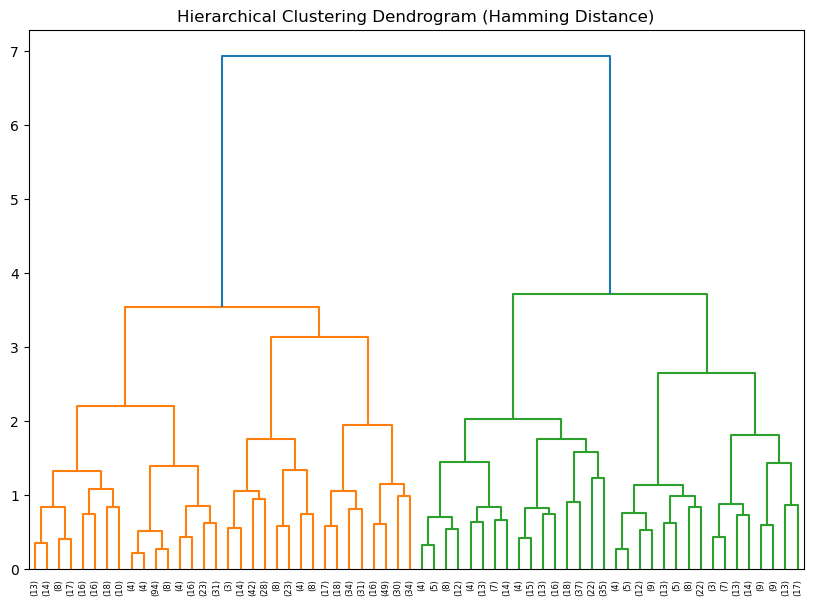

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram (Hamming Distance)")
dendrogram(hamming_linkage, truncate_mode="level", p=5)
plt.show()

In [ ]:
cluster_labels = fcluster(hamming_linkage, t=5, criterion='maxclust')

In [ ]:
y["cluster"] = cluster_labels

In [ ]:
grouped_drugs = y.groupby('cluster').sum()

# Display the drugs captured in each cluster
print(grouped_drugs)

         Amphet  Coke  Crack  Meth  Benzos  Heroin  Legalh  Amyl  VSA  LSD  \
cluster                                                                      
1           110    33      8   113     221      11      78    10   15   15   
2            33   130     13     6      41      12      68    24   11    5   
3             9     6      4     3       4       3     110    26   14   89   
4           155   113      5    54     121       8     188    34   30  187   
5           129   135     49   144     148      84     120    39   25   84   

         Mushrooms  Ketamine  Ecstasy  
cluster                                
1               29         2       31  
2               28        26       85  
3              106        20       88  
4              193        84      181  
5               78        76      132  


## MLSMOTE

In [ ]:
from sklearn.neighbors import NearestNeighbors
import random

In [ ]:
y.shape

(1885, 18)

In [ ]:
np.unique(y, axis=0).shape

(654, 18)

In [ ]:
(y.value_counts()).sum()

1885

In [ ]:
def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [ ]:
get_tail_label(y)

['Amyl', 'Coke', 'Heroin', 'Ketamine', 'LSD', 'Meth', 'Mushrooms', 'VSA']

In [ ]:
X_sub, y_sub = get_minority_samples(X, y)

In [ ]:
X_res, y_res = MLSMOTE(X_sub, y_sub, 500, 5)

In [ ]:
X_new = pd.concat([X, X_res], axis=0)
y_new = pd.concat([y, y_res], axis=0)

In [ ]:
X_new.shape, y_new.shape

((2385, 16), (2385, 18))

## trai test split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [46]:
X_train.shape, X_test.shape

((1508, 7), (377, 7))

## OneVsRest

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, hamming_loss

In [ ]:
#logistic_clf = MultiOutputClassifier(LogisticRegression())
logistic_clf = OneVsRestClassifier(LogisticRegression())

In [ ]:
logistic_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
preds = logistic_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, preds)

0.4297082228116711

In [ ]:
y_test.shape

(377, 13)

In [ ]:
hamming_loss(y_test, preds)

0.15649867374005305

In [ ]:
loss = 0
for i in range(y_test.shape[0]):
    h_loss =hamming_loss(y_test.to_numpy()[i], preds[i])
    loss += h_loss
print(loss / y_test.shape[0])

0.15649867374005327


In [ ]:
print(y_test.iloc[4:5, :].to_numpy())
print(preds[4:5, :])

[[1 1 0 1 1 1 1 0 0 1 1 1 1]]
[[1 1 0 0 1 0 1 0 0 1 1 1 1]]


In [ ]:
# Initialize the base classifier
base_rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)

# Initialize the MultiOutputClassifier with the base classifier
multi_rf = MultiOutputClassifier(base_rf, n_jobs=-1)

# Fit the model
multi_rf.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Hamming Loss: {hamming:.4f}')

y_pred = multi_rf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
hamming = hamming_loss(y_train, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Hamming Loss: {hamming:.4f}')

Accuracy: 0.4403
Hamming Loss: 0.1547
Accuracy: 0.4635
Hamming Loss: 0.1298


## MLKNN

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.neighbors import KNeighborsClassifier
from skmultilearn.adapt import MLkNN

In [ ]:
# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Wrap KNN with Binary Relevance for multilabel classification
#classifier = BinaryRelevance(knn)
classifier = knn

# Fit the model
classifier.fit(X_train.to_numpy(), y_train)

# Predict on the test set
y_pred = classifier.predict(X_test.to_numpy())

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

hamming = hamming_loss(y_test, y_pred)
print(f'Hamming Loss: {hamming:.4f}')

Accuracy: 0.4164
Hamming Loss: 0.1661


In [ ]:
# Initialize MLkNN classifier
classifier = MLkNN(k=5)

# Fit the model
classifier.fit(np.array(X_train), np.array(y_train))

# Predict on the test set
y_pred = classifier.predict(X_test.to_numpy())
y_pred_train = classifier.predict(X_train.to_numpy())

# Evaluate the model using Hamming loss
hamming = hamming_loss(y_test, y_pred)
print(f'Hamming Loss: {hamming:.4f}')

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

hamming = hamming_loss(y_train, y_pred_train)
print(f'Hamming Loss train: {hamming:.4f}')

accuracy = accuracy_score(y_train, y_pred_train)
print(f'Accuracy train: {accuracy:.4f}')

Hamming Loss: 0.1655
Accuracy: 0.4164
Hamming Loss train: 0.1248
Accuracy train: 0.4377


## ChianClassifer

In [ ]:
from sklearn.multioutput import ClassifierChain

## 1. Understanding Label Dependencies:

    Substance Use: Drugs like "Coke" (Cocaine) and "Crack" (Crack Cocaine) might be related.
    Party Drugs: "Ecstasy", "LSD", "Cannabis", "Mushrooms" might correlate.
    Common Use: "Alcohol", "Nicotine", and "Caffeine" are legal and commonly used, possibly indicating less correlation with illegal drugs.
    Stimulants: "Meth", "Coke", "Amphet" (Amphetamines) might be grouped.
    Psychedelics: "LSD", "Mushrooms", "Ketamine" could be placed near each other.

## 2. Proposed Order:

> Based on these correlations, a possible order could be:

    Caff (Caffeine): Commonly used stimulant, often independent of illicit drug use.
    Nicotine: Another common substance, often related to legal use.
    Alcohol: Widely used, potentially correlated with social/party drugs.
    Cannabis: Often used in combination with both legal substances and party drugs.
    Ecstasy: Party drug, possibly correlated with other recreational drugs.
    LSD: Psychedelic, often used in similar contexts as Ecstasy.
    Mushrooms: Psychedelic, related to LSD.
    Ketamine: Used recreationally, might follow other party drugs.
    Amphet: Stimulant, related to Meth and other uppers.
    Meth: Potent stimulant, likely correlated with other stimulants.
    Coke: Another stimulant, similar to Meth and Crack.
    Crack: Often related to Coke, might follow it.
    Benzos: Depressant, might be used with stimulants or to counteract them.
    Heroin: Potent depressant, often correlated with high-risk substance use.
    Legalh (Legal Highs): Synthetic drugs, might follow illicit ones.
    VSA (Volatile Substance Abuse): Inhalants, possibly correlated with high-risk behaviors.
    Choc (Chocolate): Less commonly related to other substances.
    Amyl: Nitrites, sometimes used recreationally but less common.

In [ ]:
# Initialize a base classifier
#base_classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
base_classifier = KNeighborsClassifier(n_neighbors=5)

index_list = [4, 16, 0, 5, 9, 13, 15, 11, 1, 14, 7, 8, 3, 10, 12, 17, 6, 2]

# Initialize the Classifier Chain
chain_classifier = ClassifierChain(base_classifier, order="random", random_state=42)

# Fit the model
chain_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = chain_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Hamming Loss: {hamming:.4f}')

Accuracy: 0.4324
Hamming Loss: 0.1638


## MLP

In [47]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_units):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.output = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.output(x)
        x = torch.sigmoid(x)
        return x
    

In [48]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [49]:
X_train_tensor.dtype, y_train_tensor.dtype

(torch.float32, torch.float32)

In [50]:
y_test_tensor

tensor([[1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [51]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [52]:
next(iter(train_dataset))[0].dtype

torch.float32

In [53]:
next(iter(train_dataloader))[0].dtype, next(iter(train_dataloader))[1].dtype

(torch.float32, torch.float32)

In [54]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]

In [55]:
model = MLP(input_shape, output_shape, 30)

In [56]:
model

MLP(
  (layer1): Linear(in_features=7, out_features=30, bias=True)
  (layer2): Linear(in_features=30, out_features=30, bias=True)
  (output): Linear(in_features=30, out_features=3, bias=True)
)

In [57]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [58]:
def accuracy(y_true, y_pred):
    y_pred = y_pred.round()
    correct = (y_pred == y_true).float()  # Get a tensor of 1s and 0s
    acc = correct.sum() / correct.numel()  # Mean of correct predictions
    return acc

In [59]:
torch.manual_seed(42)
start = timer()

epochs = 100

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n ---------")

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_dataloader):
        y_pred = model(X)

        loss = loss_fn(y_pred, y)

        train_acc += accuracy(y, y_pred)

        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 10 == 0:
            print(f"looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y, in test_dataloader:

            test_pred = model(X)

            test_acc += accuracy(y, test_pred)
            test_loss += loss_fn(test_pred, y)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\ntrain loss: {train_loss} | train acc: {train_acc} | val loss: {test_loss} | val acc: {test_acc}\n")

            
end = timer()
print_train_time(start, end)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 
 ---------


  4%|▍         | 4/100 [00:00<00:08, 10.67it/s]

looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.6301888227462769 | train acc: 0.7343750596046448 | val loss: 0.5353474617004395 | val acc: 0.8455209136009216

Epoch: 1 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.4163576364517212 | train acc: 0.8524305820465088 | val loss: 0.31852373480796814 | val acc: 0.894618034362793

Epoch: 2 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2822273075580597 | train acc: 0.8949651718139648 | val loss: 0.26868078112602234 | val acc: 0.8961110711097717

Epoch: 3 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 12

  7%|▋         | 7/100 [00:00<00:06, 14.45it/s]

looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.24216322600841522 | train acc: 0.9042968153953552 | val loss: 0.25698092579841614 | val acc: 0.8949999809265137

Epoch: 5 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.23729568719863892 | train acc: 0.9051650166511536 | val loss: 0.25346559286117554 | val acc: 0.8978472352027893

Epoch: 6 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.23570650815963745 | train acc: 0.9045140743255615 | val loss: 0.25226473808288574 | val acc: 0.901562511920929

Epoch: 7 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

trai

 12%|█▏        | 12/100 [00:00<00:05, 17.58it/s]

looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.23309604823589325 | train acc: 0.905164897441864 | val loss: 0.24949796497821808 | val acc: 0.9000694751739502

Epoch: 9 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.23162150382995605 | train acc: 0.9040799140930176 | val loss: 0.24929994344711304 | val acc: 0.9000694751739502

Epoch: 10 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22987760603427887 | train acc: 0.9055989384651184 | val loss: 0.24929702281951904 | val acc: 0.8977083563804626

Epoch: 11 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.23328624665737152

 15%|█▌        | 15/100 [00:00<00:04, 18.73it/s]

looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.23191790282726288 | train acc: 0.9060329794883728 | val loss: 0.24860693514347076 | val acc: 0.8994445204734802

Epoch: 13 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22739601135253906 | train acc: 0.9062498211860657 | val loss: 0.2524358928203583 | val acc: 0.8993403315544128

Epoch: 14 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22633536159992218 | train acc: 0.9069010615348816 | val loss: 0.24796682596206665 | val acc: 0.9005556106567383

Epoch: 15 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22685475647449493 | train acc: 0.908203184604

 20%|██        | 20/100 [00:01<00:04, 19.36it/s]

looked at 1280 / 1508 samples

train loss: 0.22638142108917236 | train acc: 0.905599057674408 | val loss: 0.24838566780090332 | val acc: 0.8985764980316162

Epoch: 17 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22524482011795044 | train acc: 0.9069010615348816 | val loss: 0.24750261008739471 | val acc: 0.8979514241218567

Epoch: 18 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22486889362335205 | train acc: 0.909071147441864 | val loss: 0.2478078454732895 | val acc: 0.8996875882148743

Epoch: 19 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22826410830020905 | train acc: 0.904296875 | val loss: 0.24859845638275146 |

 23%|██▎       | 23/100 [00:01<00:03, 19.79it/s]


train loss: 0.23006512224674225 | train acc: 0.90625 | val loss: 0.2470775693655014 | val acc: 0.8985764384269714

Epoch: 21 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22617805004119873 | train acc: 0.9086371064186096 | val loss: 0.24943490326404572 | val acc: 0.900069534778595

Epoch: 22 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22784924507141113 | train acc: 0.9038627743721008 | val loss: 0.24827761948108673 | val acc: 0.9011805653572083

Epoch: 23 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22431844472885132 | train acc: 0.9086372256278992 | val loss: 0.24666564166545868 | val acc: 0.8996875286102295

Epo

 29%|██▉       | 29/100 [00:01<00:03, 20.17it/s]

looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22295336425304413 | train acc: 0.9090710282325745 | val loss: 0.24824361503124237 | val acc: 0.8977084159851074

Epoch: 26 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22414632141590118 | train acc: 0.908203125 | val loss: 0.24788536131381989 | val acc: 0.9005555510520935

Epoch: 27 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22566747665405273 | train acc: 0.9038628935813904 | val loss: 0.2496020644903183 | val acc: 0.8983333110809326

Epoch: 28 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22293907403945923 | tra

 32%|███▏      | 32/100 [00:01<00:03, 19.95it/s]

looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22105096280574799 | train acc: 0.909071147441864 | val loss: 0.25272271037101746 | val acc: 0.8989583849906921

Epoch: 30 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22188395261764526 | train acc: 0.905381977558136 | val loss: 0.24981309473514557 | val acc: 0.8994445204734802

Epoch: 31 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22078441083431244 | train acc: 0.9088541865348816 | val loss: 0.2507660388946533 | val acc: 0.9000694751739502

Epoch: 32 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22050388157367706 | train acc: 0.90733522176742

 35%|███▌      | 35/100 [00:01<00:03, 19.54it/s]

looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21873287856578827 | train acc: 0.9099392294883728 | val loss: 0.25032684206962585 | val acc: 0.8992013931274414

Epoch: 34 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22474347054958344 | train acc: 0.9086372256278992 | val loss: 0.25020280480384827 | val acc: 0.8992014527320862

Epoch: 35 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21717287600040436 | train acc: 0.9121094346046448 | val loss: 0.24826572835445404 | val acc: 0.8985764384269714

Epoch: 36 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples


 40%|████      | 40/100 [00:02<00:03, 18.69it/s]

looked at 1280 / 1508 samples

train loss: 0.22204844653606415 | train acc: 0.9071180820465088 | val loss: 0.24830001592636108 | val acc: 0.8988194465637207

Epoch: 37 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22784675657749176 | train acc: 0.907118022441864 | val loss: 0.24930526316165924 | val acc: 0.8988195061683655

Epoch: 38 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21874932944774628 | train acc: 0.9084201455116272 | val loss: 0.2490883320569992 | val acc: 0.8994444012641907

Epoch: 39 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21783997118473053 | train acc: 0.9116753935813904 | val loss: 0.25009635090

 45%|████▌     | 45/100 [00:02<00:02, 19.46it/s]


train loss: 0.2167133092880249 | train acc: 0.9097222685813904 | val loss: 0.24815259873867035 | val acc: 0.8988194465637207

Epoch: 41 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21860520541667938 | train acc: 0.9097223281860352 | val loss: 0.2513388693332672 | val acc: 0.8994445204734802

Epoch: 42 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21726615726947784 | train acc: 0.9095051884651184 | val loss: 0.24957771599292755 | val acc: 0.8985764384269714

Epoch: 43 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22208277881145477 | train acc: 0.9077691435813904 | val loss: 0.2498232126235962 | val acc: 0.90031248331

 49%|████▉     | 49/100 [00:02<00:02, 19.51it/s]

looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22011001408100128 | train acc: 0.9095051884651184 | val loss: 0.2513626515865326 | val acc: 0.9011805653572083

Epoch: 46 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2144826203584671 | train acc: 0.9134113192558289 | val loss: 0.2504197955131531 | val acc: 0.9011805653572083

Epoch: 47 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2162960171699524 | train acc: 0.9095051884651184 | val loss: 0.25188741087913513 | val acc: 0.9003124833106995

Epoch: 48 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

trai

 52%|█████▏    | 52/100 [00:02<00:02, 19.82it/s]

looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.22331680357456207 | train acc: 0.908854067325592 | val loss: 0.25098031759262085 | val acc: 0.9003124833106995

Epoch: 50 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2145870476961136 | train acc: 0.9101561903953552 | val loss: 0.2520003914833069 | val acc: 0.8992014527320862

Epoch: 51 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21713852882385254 | train acc: 0.9097221493721008 | val loss: 0.25224336981773376 | val acc: 0.8983333706855774

Epoch: 52 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

tra

 57%|█████▋    | 57/100 [00:03<00:02, 19.92it/s]

looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21253333985805511 | train acc: 0.9112412333488464 | val loss: 0.25287362933158875 | val acc: 0.8965972065925598

Epoch: 54 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2134322077035904 | train acc: 0.913411557674408 | val loss: 0.2513786554336548 | val acc: 0.8974652886390686

Epoch: 55 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21316157281398773 | train acc: 0.9097222685813904 | val loss: 0.2513190805912018 | val acc: 0.8953471779823303

Epoch: 56 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21331824362277985 |

 59%|█████▉    | 59/100 [00:03<00:02, 19.85it/s]

looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21285732090473175 | train acc: 0.9125434756278992 | val loss: 0.251829594373703 | val acc: 0.8931249976158142

Epoch: 58 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21228672564029694 | train acc: 0.9134113788604736 | val loss: 0.25231608748435974 | val acc: 0.8922569751739502

Epoch: 59 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20947426557540894 | train acc: 0.9134114384651184 | val loss: 0.25380387902259827 | val acc: 0.8922569751739502

Epoch: 60 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20771092176437378

 65%|██████▌   | 65/100 [00:03<00:01, 20.17it/s]

looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2089930921792984 | train acc: 0.9147136211395264 | val loss: 0.25511133670806885 | val acc: 0.893125057220459

Epoch: 62 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2154027670621872 | train acc: 0.912543535232544 | val loss: 0.25442999601364136 | val acc: 0.8974652886390686

Epoch: 63 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2096877098083496 | train acc: 0.9138455390930176 | val loss: 0.2522173225879669 | val acc: 0.8922569751739502

Epoch: 64 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2099006325006485 | train acc: 0.9116753935813904 |

 68%|██████▊   | 68/100 [00:03<00:01, 20.17it/s]

looked at 1280 / 1508 samples

train loss: 0.2070450633764267 | train acc: 0.9162325859069824 | val loss: 0.2552933990955353 | val acc: 0.8948611617088318

Epoch: 66 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2096455693244934 | train acc: 0.9116752743721008 | val loss: 0.254997581243515 | val acc: 0.893125057220459

Epoch: 67 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21050117909908295 | train acc: 0.9147135615348816 | val loss: 0.2544387876987457 | val acc: 0.8968402743339539

Epoch: 68 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.21057479083538055 | train acc: 0.9144964218139648 | val loss: 0.2533847391605377

 74%|███████▍  | 74/100 [00:03<00:01, 20.23it/s]


train loss: 0.2060333490371704 | train acc: 0.9142796397209167 | val loss: 0.25486546754837036 | val acc: 0.893125057220459

Epoch: 70 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20781487226486206 | train acc: 0.9121094346046448 | val loss: 0.256174772977829 | val acc: 0.8948611617088318

Epoch: 71 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2134801596403122 | train acc: 0.9101564288139343 | val loss: 0.25490841269493103 | val acc: 0.8922569751739502

Epoch: 72 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20716412365436554 | train acc: 0.9149306416511536 | val loss: 0.25689640641212463 | val acc: 0.8917708396911

 80%|████████  | 80/100 [00:04<00:01, 18.40it/s]

looked at 1280 / 1508 samples

train loss: 0.2057093232870102 | train acc: 0.9157984852790833 | val loss: 0.25767281651496887 | val acc: 0.8939931392669678

Epoch: 77 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20481859147548676 | train acc: 0.9164496064186096 | val loss: 0.2565372884273529 | val acc: 0.8968402743339539

Epoch: 78 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20291592180728912 | train acc: 0.9162325859069824 | val loss: 0.25597214698791504 | val acc: 0.893993079662323

Epoch: 79 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20674113929271698 | train acc: 0.9151475429534912 | val loss: 0.257309406995

 83%|████████▎ | 83/100 [00:04<00:00, 19.02it/s]


train loss: 0.20530706644058228 | train acc: 0.9123263359069824 | val loss: 0.2586398720741272 | val acc: 0.8920139670372009

Epoch: 81 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20330990850925446 | train acc: 0.9155815243721008 | val loss: 0.25906652212142944 | val acc: 0.8920139670372009

Epoch: 82 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2062687873840332 | train acc: 0.9123263359069824 | val loss: 0.25810685753822327 | val acc: 0.8939931392669678

Epoch: 83 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2030431181192398 | train acc: 0.9164497256278992 | val loss: 0.25710779428482056 | val acc: 0.89572924375

 86%|████████▌ | 86/100 [00:04<00:00, 19.52it/s]

looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20226578414440155 | train acc: 0.9147135615348816 | val loss: 0.2581195831298828 | val acc: 0.8920139670372009

Epoch: 86 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20427997410297394 | train acc: 0.9140625596046448 | val loss: 0.25760170817375183 | val acc: 0.8957292437553406

Epoch: 87 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20206189155578613 | train acc: 0.916666567325592 | val loss: 0.2582460939884186 | val acc: 0.8959722518920898



 90%|█████████ | 90/100 [00:04<00:00, 17.18it/s]

Epoch: 88 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2018072009086609 | train acc: 0.9157986640930176 | val loss: 0.2566763162612915 | val acc: 0.8942360877990723

Epoch: 89 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20561401546001434 | train acc: 0.9129772186279297 | val loss: 0.25851181149482727 | val acc: 0.8965972065925598

Epoch: 90 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20857290923595428 | train acc: 0.9112412929534912 | val loss: 0.2588072121143341 | val acc: 0.8965972065925598

Epoch: 91 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples


 94%|█████████▍| 94/100 [00:05<00:00, 16.92it/s]

looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20060913264751434 | train acc: 0.9171008467674255 | val loss: 0.25944212079048157 | val acc: 0.8974652290344238

Epoch: 92 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20352090895175934 | train acc: 0.912109375 | val loss: 0.26205238699913025 | val acc: 0.8917708396911621

Epoch: 93 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.2012830376625061 | train acc: 0.914713442325592 | val loss: 0.2591265141963959 | val acc: 0.8957292437553406

Epoch: 94 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20123399794101715 | train

 97%|█████████▋| 97/100 [00:05<00:00, 17.74it/s]

looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.19952203333377838 | train acc: 0.9142794609069824 | val loss: 0.2595749795436859 | val acc: 0.8948611617088318

Epoch: 96 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.20269525051116943 | train acc: 0.9138455390930176 | val loss: 0.2610706090927124 | val acc: 0.893993079662323

Epoch: 97 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.1996910721063614 | train acc: 0.9157986044883728 | val loss: 0.2649052143096924 | val acc: 0.8926389217376709

Epoch: 98 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples


100%|██████████| 100/100 [00:05<00:00, 18.31it/s]

looked at 1280 / 1508 samples

train loss: 0.1988070011138916 | train acc: 0.9155816435813904 | val loss: 0.2611263692378998 | val acc: 0.8965972065925598

Epoch: 99 
 ---------
looked at 0 / 1508 samples
looked at 320 / 1508 samples
looked at 640 / 1508 samples
looked at 960 / 1508 samples
looked at 1280 / 1508 samples

train loss: 0.19994103908538818 | train acc: 0.915147602558136 | val loss: 0.26077935099601746 | val acc: 0.8948610424995422


train time: 5.464459810999983


In [60]:
model.eval()

with torch.inference_mode():

    total_h_loss = 0
    total_acc = 0
    for X, y in test_dataloader:
        y_pred = model(X)
        acc = accuracy(y, y_pred)
        h_loss = hamming_loss(y, y_pred.round())
        total_h_loss += h_loss
        total_acc += acc
    print(total_h_loss/ len(test_dataloader))
    print(total_acc / len(test_dataloader))

    total_h_loss = 0
    total_acc = 0
    for X, y in train_dataloader:
        y_pred = model(X)
        acc = accuracy(y, y_pred)
        h_loss = hamming_loss(y, y_pred.round())
        total_h_loss += h_loss
        total_acc += acc
    print(total_h_loss/ len(train_dataloader))
    print(total_acc / len(train_dataloader))

0.10513888888888889
tensor(0.8949)
0.08311631944444446
tensor(0.9169)


In [57]:
model.eval()
scripted_model = torch.jit.script(model)  # Or torch.jit.trace(model, example_input)
scripted_model.save("mlp_model.pt")

In [62]:
temp = {"A": 1.27, "B": -0.45, "C": 0.85, "D": -1.75, "E": 0.65, "F": -0.35, "G": 1.20}

In [95]:
model.eval()
with torch.inference_mode():
    tmp = torch.tensor(np.array(list(zip(temp.values()))), dtype=torch.float32)
    tmp = tmp.transpose(0, 1)
    pred = model(tmp)
    print(pred)

tensor([[1.0000, 0.9900, 0.8514]])


In [87]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 7])